In [13]:
#imports & paths

import os
from pathlib import Path
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings("ignore", message="Your `PyDataset` class should call")
warnings.filterwarnings("ignore", message="Precision is ill-defined")

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix

print("TensorFlow version:", tf.__version__)

# ---- YOUR PROJECT ROOT ----
PROJECT_ROOT = Path("C:/Users/beena/Aerial_Project").resolve()
print("PROJECT_ROOT:", PROJECT_ROOT)

# ---- CLASSIFICATION PATHS ----
CLASS_TRAIN_DIR = PROJECT_ROOT / "data" / "Classification" / "Train_class" / "train"
CLASS_VAL_DIR   = PROJECT_ROOT / "data" / "Classification" / "Valid_class" / "valid"
CLASS_TEST_DIR  = PROJECT_ROOT / "data" / "Classification" / "Test_class" / "test"

print("CLASS_TRAIN_DIR:", CLASS_TRAIN_DIR, "exists:", CLASS_TRAIN_DIR.exists())
print("CLASS_VAL_DIR:  ", CLASS_VAL_DIR,   "exists:", CLASS_VAL_DIR.exists())
print("CLASS_TEST_DIR: ", CLASS_TEST_DIR,  "exists:", CLASS_TEST_DIR.exists())

# ---- DETECTION PATHS (YOLO-style images + labels) ----
# This assumes: Train\train\images, Train\train\labels, etc.
DETECT_TRAIN_IMG_DIR = PROJECT_ROOT / "data" / "Detection" / "Train" / "train" / "images"
DETECT_TRAIN_LABEL_DIR = PROJECT_ROOT / "data" / "Detection" / "Train" / "train" / "labels"

DETECT_VAL_IMG_DIR = PROJECT_ROOT / "data" / "Detection" / "Valid" / "valid" / "images"
DETECT_VAL_LABEL_DIR = PROJECT_ROOT / "data" / "Detection" / "Valid" / "valid" / "labels"

DETECT_TEST_IMG_DIR = PROJECT_ROOT / "data" / "Detection" / "Test" / "test" / "images"
DETECT_TEST_LABEL_DIR = PROJECT_ROOT / "data" / "Detection" / "Test" / "test" / "labels"

print("\nDetection dirs:")
print("TRAIN images:", DETECT_TRAIN_IMG_DIR, "exists:", DETECT_TRAIN_IMG_DIR.exists())
print("TRAIN labels:", DETECT_TRAIN_LABEL_DIR, "exists:", DETECT_TRAIN_LABEL_DIR.exists())
print("VAL   images:", DETECT_VAL_IMG_DIR, "exists:", DETECT_VAL_IMG_DIR.exists())
print("VAL   labels:", DETECT_VAL_LABEL_DIR, "exists:", DETECT_VAL_LABEL_DIR.exists())
print("TEST  images:", DETECT_TEST_IMG_DIR, "exists:", DETECT_TEST_IMG_DIR.exists())
print("TEST  labels:", DETECT_TEST_LABEL_DIR, "exists:", DETECT_TEST_LABEL_DIR.exists())

# ---- Common training config ----
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42


TensorFlow version: 2.20.0
PROJECT_ROOT: C:\Users\beena\Aerial_Project
CLASS_TRAIN_DIR: C:\Users\beena\Aerial_Project\data\Classification\Train_class\train exists: True
CLASS_VAL_DIR:   C:\Users\beena\Aerial_Project\data\Classification\Valid_class\valid exists: True
CLASS_TEST_DIR:  C:\Users\beena\Aerial_Project\data\Classification\Test_class\test exists: True

Detection dirs:
TRAIN images: C:\Users\beena\Aerial_Project\data\Detection\Train\train\images exists: True
TRAIN labels: C:\Users\beena\Aerial_Project\data\Detection\Train\train\labels exists: True
VAL   images: C:\Users\beena\Aerial_Project\data\Detection\Valid\valid\images exists: True
VAL   labels: C:\Users\beena\Aerial_Project\data\Detection\Valid\valid\labels exists: True
TEST  images: C:\Users\beena\Aerial_Project\data\Detection\Test\test\images exists: True
TEST  labels: C:\Users\beena\Aerial_Project\data\Detection\Test\test\labels exists: True


In [2]:
#count images per split & class

def count_images_in_split(split_name, dir_path: Path):
    rows = []
    if not dir_path.exists():
        print(f"[WARN] {split_name} dir does not exist:", dir_path)
        return pd.DataFrame()
    for cls in sorted(os.listdir(dir_path)):
        cls_path = dir_path / cls
        if not cls_path.is_dir():
            continue
        n = sum(
            1 for f in os.listdir(cls_path)
            if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"))
        )
        rows.append({"split": split_name, "class": cls, "count": n, "path": str(cls_path)})
    return pd.DataFrame(rows)

df_train = count_images_in_split("train", CLASS_TRAIN_DIR)
df_val   = count_images_in_split("val", CLASS_VAL_DIR)
df_test  = count_images_in_split("test", CLASS_TEST_DIR)

counts_df = pd.concat([df_train, df_val, df_test], ignore_index=True)
if counts_df.empty:
    print("No classification images found. Check folder paths.")
else:
    display(counts_df)
    print("Total classification images:", counts_df["count"].sum())


,split,class,count,path
0,train,bird,1414,C:\Users\beena\Aerial_Project\data\Classificat...
1,train,drone,1248,C:\Users\beena\Aerial_Project\data\Classificat...
2,val,bird,217,C:\Users\beena\Aerial_Project\data\Classificat...
3,val,drone,225,C:\Users\beena\Aerial_Project\data\Classificat...
4,test,bird,121,C:\Users\beena\Aerial_Project\data\Classificat...
5,test,drone,94,C:\Users\beena\Aerial_Project\data\Classificat...


Total classification images: 3319


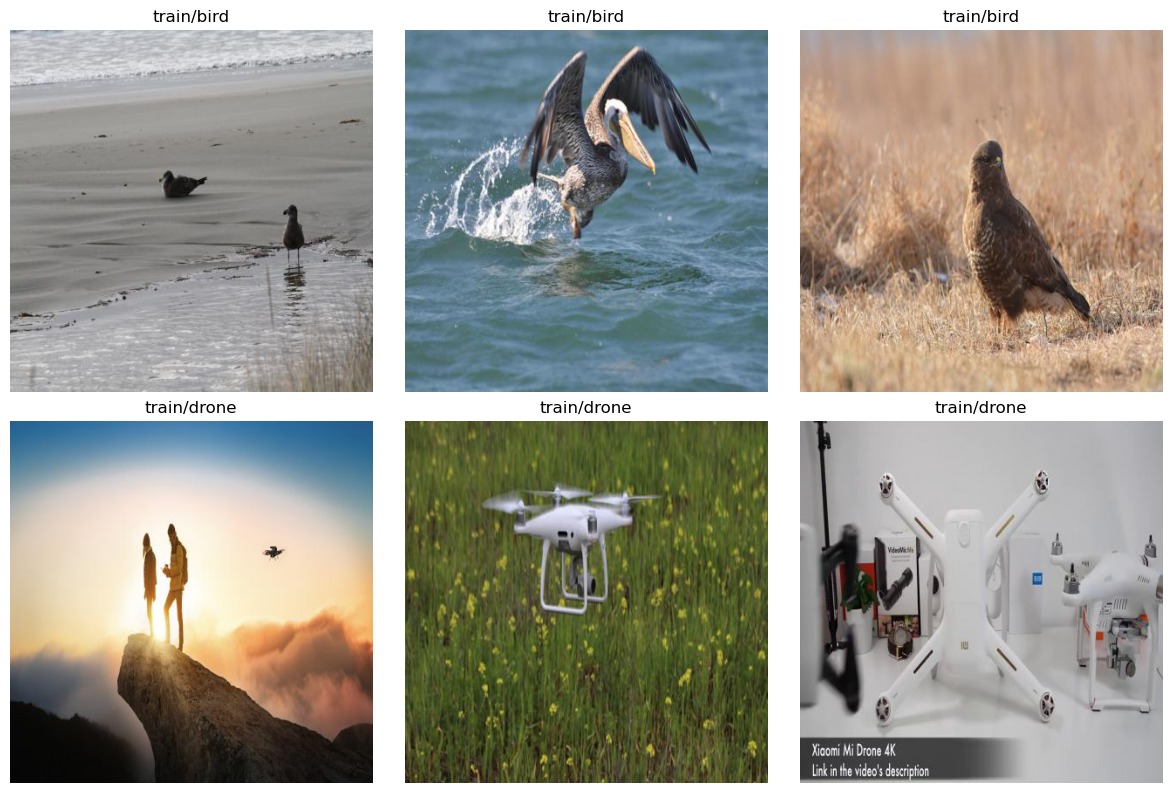

In [3]:
#visual sanity check — some train images

def show_samples(dir_path: Path, split_name="train", n_per_class=3):
    if not dir_path.exists():
        print("Missing directory:", dir_path)
        return
    
    classes = [d for d in os.listdir(dir_path) if (dir_path / d).is_dir()]
    if not classes:
        print("No class folders under", dir_path)
        return
    
    plt.figure(figsize=(4 * n_per_class, 4 * len(classes)))
    i = 1
    for cls in classes:
        cls_dir = dir_path / cls
        files = [f for f in os.listdir(cls_dir)
                 if f.lower().endswith((".jpg",".jpeg",".png",".bmp",".webp"))]
        if not files:
            continue
        sample = random.sample(files, min(n_per_class, len(files)))
        for fname in sample:
            img_path = cls_dir / fname
            img = Image.open(img_path).convert("RGB")
            plt.subplot(len(classes), n_per_class, i)
            plt.imshow(img)
            plt.axis("off")
            plt.title(f"{split_name}/{cls}")
            i += 1
    plt.tight_layout()
    plt.show()

show_samples(CLASS_TRAIN_DIR, split_name="train", n_per_class=3)


,width,height,area
count,500.0,500.0,500.0
mean,416.0,416.0,173056.0
std,0.0,0.0,0.0
min,416.0,416.0,173056.0
25%,416.0,416.0,173056.0
50%,416.0,416.0,173056.0
75%,416.0,416.0,173056.0
max,416.0,416.0,173056.0


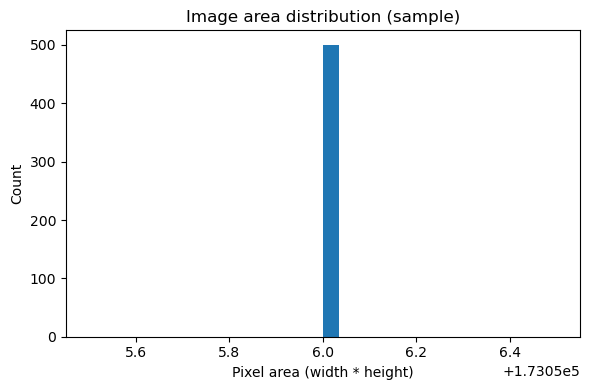

In [4]:
#image size stats from train / val / test (classification)

def sample_image_sizes(dirs, max_samples=500):
    paths = []
    for d in dirs:
        if not d.exists():
            continue
        for cls in os.listdir(d):
            cls_dir = d / cls
            if not cls_dir.is_dir():
                continue
            for f in os.listdir(cls_dir):
                if f.lower().endswith((".jpg",".jpeg",".png",".bmp",".webp")):
                    paths.append(cls_dir / f)
    random.shuffle(paths)
    paths = paths[:max_samples]
    
    rows = []
    for p in paths:
        try:
            with Image.open(p) as im:
                w, h = im.size
                rows.append({"path": str(p), "width": w, "height": h, "area": w*h})
        except Exception as e:
            print("Error reading", p, "->", e)
    return pd.DataFrame(rows)

sizes_df = sample_image_sizes([CLASS_TRAIN_DIR, CLASS_VAL_DIR, CLASS_TEST_DIR], max_samples=500)

if not sizes_df.empty:
    display(sizes_df[["width","height","area"]].describe())
    plt.figure(figsize=(6,4))
    plt.hist(sizes_df["area"], bins=30)
    plt.xlabel("Pixel area (width * height)")
    plt.ylabel("Count")
    plt.title("Image area distribution (sample)")
    plt.tight_layout()
    plt.show()
else:
    print("No images sampled; check classification dataset structure.")


In [5]:
#YOLO label validation for detection dataset (train/val/test)

def validate_yolo_split(img_dir: Path, label_dir: Path, split_name: str):
    report = {"split": split_name, "image_count": 0, "label_files": 0, "empty": [], "malformed": []}
    if not img_dir.exists() or not label_dir.exists():
        print(f"[WARN] {split_name}: missing img_dir or label_dir")
        return report
    
    # count images
    img_files = [f for f in img_dir.iterdir()
                 if f.suffix.lower() in [".jpg",".jpeg",".png",".bmp",".webp"]]
    report["image_count"] = len(img_files)

    # check labels
    txt_files = list(label_dir.glob("*.txt"))
    report["label_files"] = len(txt_files)
    for f in txt_files:
        lines = [l.strip() for l in open(f, "r", encoding="utf-8").read().splitlines() if l.strip()]
        if not lines:
            report["empty"].append(str(f))
            continue
        for ln in lines:
            parts = ln.split()
            if len(parts) != 5:
                report["malformed"].append({"file": str(f), "line": ln, "reason": "expected 5 tokens"})
                break
            try:
                [float(x) for x in parts]
            except:
                report["malformed"].append({"file": str(f), "line": ln, "reason": "non-numeric token"})
                break
    return report

yolo_train = validate_yolo_split(DETECT_TRAIN_IMG_DIR, DETECT_TRAIN_LABEL_DIR, "train")
yolo_val   = validate_yolo_split(DETECT_VAL_IMG_DIR,   DETECT_VAL_LABEL_DIR,   "val")
yolo_test  = validate_yolo_split(DETECT_TEST_IMG_DIR,  DETECT_TEST_LABEL_DIR,  "test")

yolo_report = [yolo_train, yolo_val, yolo_test]
pd.DataFrame([
    {
        "split": r["split"],
        "images": r["image_count"],
        "label_files": r["label_files"],
        "empty_labels": len(r["empty"]),
        "malformed_labels": len(r["malformed"])
    }
    for r in yolo_report
])


,split,images,label_files,empty_labels,malformed_labels
0,train,2728,2728,66,0
1,val,448,448,6,0
2,test,224,224,9,0


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

val_test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_gen = train_datagen.flow_from_directory(
    CLASS_TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode="rgb",          # <- force 3 channels
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=True,
    seed=SEED
)

val_gen = val_test_datagen.flow_from_directory(
    CLASS_VAL_DIR,
    target_size=IMG_SIZE,
    color_mode="rgb",          # <- force 3 channels
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    CLASS_TEST_DIR,
    target_size=IMG_SIZE,
    color_mode="rgb",          # <- force 3 channels
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

print("Class indices:", train_gen.class_indices)


Found 2662 images belonging to 2 classes.
Found 442 images belonging to 2 classes.
Found 215 images belonging to 2 classes.
Class indices: {'bird': 0, 'drone': 1}


In [7]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
import tensorflow as tf

def build_classifier(input_shape=IMG_SIZE + (3,)):
    # NOTE: weights=None to avoid shape mismatch with grayscale history
    base = EfficientNetB0(
        include_top=False,
        weights=None,           # <- IMPORTANT: no pretrained weights
        input_shape=input_shape
    )
    base.trainable = True      # we’re training from scratch

    inputs = layers.Input(shape=input_shape)
    x = base(inputs, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_classifier()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 4,008,829 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [8]:
EPOCHS = 5

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_gen,
    epochs=EPOCHS,
    validation_data=val_gen,
    callbacks=callbacks
)


Epoch 1/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 880s 10s/step - accuracy: 0.6698 - loss: 0.6145 - val_accuracy: 0.4910 - val_loss: 0.7433 - learning_rate: 0.0010
Epoch 2/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 683s 8s/step - accuracy: 0.7479 - loss: 0.5103 - val_accuracy: 0.4910 - val_loss: 0.7334 - learning_rate: 0.0010
Epoch 3/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 670s 8s/step - accuracy: 0.7964 - loss: 0.4426 - val_accuracy: 0.4910 - val_loss: 2.0348 - learning_rate: 0.0010
Epoch 4/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8175 - loss: 0.3894   
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
84/84 ━━━━━━━━━━━━━━━━━━━━ 715s 8s/step - accuracy: 0.8212 - loss: 0.3919 - val_accuracy: 0.4910 - val_loss: 0.7809 - learning_rate: 0.0010
Epoch 5/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 1495s 18s/step - accuracy: 0.8494 - loss: 0.3664 - val_accuracy: 0.4910 - val_loss: 1.4562 - learning_rate: 5.0000e-04
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


In [9]:
#Check class distribution in train / val / test

def count_split(dir_path: Path, split_name: str):
    rows = []
    if not dir_path.exists():
        print(f"[WARN] {split_name} dir does not exist:", dir_path)
        return pd.DataFrame()
    for cls in sorted(os.listdir(dir_path)):
        cls_path = dir_path / cls
        if not cls_path.is_dir():
            continue
        n = sum(
            1 for f in os.listdir(cls_path)
            if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"))
        )
        rows.append({"split": split_name, "class": cls, "count": n, "path": str(cls_path)})
    return pd.DataFrame(rows)

df_train = count_split(CLASS_TRAIN_DIR, "train")
df_val   = count_split(CLASS_VAL_DIR,   "val")
df_test  = count_split(CLASS_TEST_DIR,  "test")

counts_df = pd.concat([df_train, df_val, df_test], ignore_index=True)
display(counts_df)
print("Total images:", counts_df["count"].sum())


,split,class,count,path
0,train,bird,1414,C:\Users\beena\Aerial_Project\data\Classificat...
1,train,drone,1248,C:\Users\beena\Aerial_Project\data\Classificat...
2,val,bird,217,C:\Users\beena\Aerial_Project\data\Classificat...
3,val,drone,225,C:\Users\beena\Aerial_Project\data\Classificat...
4,test,bird,121,C:\Users\beena\Aerial_Project\data\Classificat...
5,test,drone,94,C:\Users\beena\Aerial_Project\data\Classificat...


Total images: 3319


In [14]:
# Evaluate on VALIDATION set (not test yet)

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

val_gen.reset()
val_probs = model.predict(val_gen)
val_pred = (val_probs.ravel() >= 0.5).astype(int)
val_true = val_gen.classes

class_indices = val_gen.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
print("Class mapping:", idx_to_class)

print("\nVALIDATION classification report:\n")
print(classification_report(
    val_true,
    val_pred,
    target_names=[idx_to_class[0], idx_to_class[1]]
))

val_cm = confusion_matrix(val_true, val_pred)
print("Validation confusion matrix:\n", val_cm)


14/14 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step
Class mapping: {0: 'bird', 1: 'drone'}

VALIDATION classification report:

              precision    recall  f1-score   support

        bird       0.49      1.00      0.66       217
       drone       0.00      0.00      0.00       225

    accuracy                           0.49       442
   macro avg       0.25      0.50      0.33       442
weighted avg       0.24      0.49      0.32       442

Validation confusion matrix:
 [[217   0]
 [225   0]]


In [11]:
#Compute class weights from train_gen

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_train = train_gen.classes               # 0/1 labels from generator
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)
class_weight = {int(c): float(w) for c, w in zip(classes, class_weights)}

print("Class weight mapping:", class_weight)


Class weight mapping: {0: 0.9413012729844413, 1: 1.0665064102564104}


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# ---- VALIDATION EVAL ----
val_gen.reset()
val_probs = model.predict(val_gen)
val_pred = (val_probs.ravel() >= 0.5).astype(int)
val_true = val_gen.classes

class_indices = val_gen.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
print("Class mapping:", idx_to_class)

print("\nVALIDATION classification report:\n")
print(classification_report(
    val_true,
    val_pred,
    target_names=[idx_to_class[0], idx_to_class[1]]
))

print("Validation confusion matrix:\n", confusion_matrix(val_true, val_pred))

# ---- TEST EVAL ----
test_gen.reset()
test_probs = model.predict(test_gen)
test_pred = (test_probs.ravel() >= 0.5).astype(int)
test_true = test_gen.classes

print("\nTEST classification report:\n")
print(classification_report(
    test_true,
    test_pred,
    target_names=[idx_to_class[0], idx_to_class[1]]
))

print("Test confusion matrix:\n", confusion_matrix(test_true, test_pred))


14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step
Class mapping: {0: 'bird', 1: 'drone'}

VALIDATION classification report:

              precision    recall  f1-score   support

        bird       0.49      1.00      0.66       217
       drone       0.00      0.00      0.00       225

    accuracy                           0.49       442
   macro avg       0.25      0.50      0.33       442
weighted avg       0.24      0.49      0.32       442

Validation confusion matrix:
 [[217   0]
 [225   0]]
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step

TEST classification report:

              precision    recall  f1-score   support

        bird       0.56      1.00      0.72       121
       drone       0.00      0.00      0.00        94

    accuracy                           0.56       215
   macro avg       0.28      0.50      0.36       215
weighted avg       0.32      0.56      0.41       215

Test confusion matrix:
 [[121   0]
 [ 94   0]]


In [16]:
#compute class weights + define callbacks (used by both models)

from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf

# class weights to handle any imbalance
y_train = train_gen.classes
classes = np.unique(y_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight = {int(c): float(w) for c, w in zip(classes, weights)}
print("Class weights:", class_weight)

# callbacks (reuse for all models)
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=3, restore_best_weights=True, verbose=1
    )
]


Class weights: {0: 0.9413012729844413, 1: 1.0665064102564104}


In [17]:
#Custom CNN model

from tensorflow.keras import layers, models

def build_custom_cnn(input_shape=IMG_SIZE + (3,)):
    inputs = layers.Input(shape=input_shape)

    # Block 1
    x = layers.Conv2D(32, (3,3), padding="same", activation="relu")(inputs)
    x = layers.MaxPooling2D((2,2))(x)

    # Block 2
    x = layers.Conv2D(64, (3,3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Block 3
    x = layers.Conv2D(128, (3,3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x)

    # Block 4 (slightly deeper)
    x = layers.Conv2D(256, (3,3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

custom_cnn = build_custom_cnn()
custom_cnn.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │      12,845,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,233,985 (50.48 MB)

 Trainable params: 13,233,985 (50.48 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train Custom CNN

EPOCHS_CNN = 10  # you can reduce to 5 if too slow

history_cnn = custom_cnn.fit(
    train_gen,
    epochs=EPOCHS_CNN,
    validation_data=val_gen,
    callbacks=callbacks,
    class_weight=class_weight
)


Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 302s 3s/step - accuracy: 0.5473 - loss: 0.7246 - val_accuracy: 0.6448 - val_loss: 0.6074 - learning_rate: 0.0010
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 272s 3s/step - accuracy: 0.6927 - loss: 0.5863 - val_accuracy: 0.7308 - val_loss: 0.5474 - learning_rate: 0.0010
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 227s 3s/step - accuracy: 0.7374 - loss: 0.5401 - val_accuracy: 0.7489 - val_loss: 0.5172 - learning_rate: 0.0010
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step - accuracy: 0.7633 - loss: 0.4933 - val_accuracy: 0.7715 - val_loss: 0.5199 - learning_rate: 0.0010
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 213s 3s/step - accuracy: 0.7908 - loss: 0.4574 - val_accuracy: 0.8054 - val_loss: 0.4381 - learning_rate: 0.0010
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.7881 - loss: 0.4498 - val_accuracy: 0.7715 - val_loss: 0.4616 - learning_rate: 0.0010
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.8103 - loss: 0.4161 - val_acc

In [19]:
#Transfer Learning model (MobileNetV2 + ImageNet)

from tensorflow.keras.applications import MobileNetV2

def build_tl_mobilenet(input_shape=IMG_SIZE + (3,)):
    base = MobileNetV2(
        include_top=False,
        weights="imagenet",      # transfer learning
        input_shape=input_shape
    )
    base.trainable = False      # Stage 1: freeze base

    inputs = layers.Input(shape=input_shape)
    x = base(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model, base

tl_model, tl_base = build_tl_mobilenet()
tl_model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [20]:
# Train TL model (Stage 1 - frozen backbone)

EPOCHS_TL_STAGE1 = 5

history_tl_1 = tl_model.fit(
    train_gen,
    epochs=EPOCHS_TL_STAGE1,
    validation_data=val_gen,
    callbacks=callbacks,
    class_weight=class_weight
)


Epoch 1/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.8606 - loss: 0.3336 - val_accuracy: 0.9208 - val_loss: 0.1877 - learning_rate: 0.0010
Epoch 2/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.9410 - loss: 0.1633 - val_accuracy: 0.9548 - val_loss: 0.1296 - learning_rate: 0.0010
Epoch 3/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.9572 - loss: 0.1296 - val_accuracy: 0.9525 - val_loss: 0.1151 - learning_rate: 0.0010
Epoch 4/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.9602 - loss: 0.1107 - val_accuracy: 0.9638 - val_loss: 0.1033 - learning_rate: 0.0010
Epoch 5/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.9647 - loss: 0.1032 - val_accuracy: 0.9638 - val_loss: 0.0984 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.


In [21]:
#  Fine-tune TL model (Stage 2 - unfreeze last layers)

tl_base.trainable = True

# Freeze most layers, unfreeze last 30 for fine-tuning
for layer in tl_base.layers[:-30]:
    layer.trainable = False

tl_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

EPOCHS_TL_STAGE2 = 5

history_tl_2 = tl_model.fit(
    train_gen,
    epochs=EPOCHS_TL_STAGE2,
    validation_data=val_gen,
    callbacks=callbacks,
    class_weight=class_weight
)


Epoch 1/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.9395 - loss: 0.1592 - val_accuracy: 0.9683 - val_loss: 0.0811 - learning_rate: 1.0000e-05
Epoch 2/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9606 - loss: 0.1060 - val_accuracy: 0.9751 - val_loss: 0.0723 - learning_rate: 1.0000e-05
Epoch 3/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.9741 - loss: 0.0802 - val_accuracy: 0.9729 - val_loss: 0.0691 - learning_rate: 1.0000e-05
Epoch 4/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9707 - loss: 0.0767 - val_accuracy: 0.9774 - val_loss: 0.0647 - learning_rate: 1.0000e-05
Epoch 5/5
84/84 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9816 - loss: 0.0576 - val_accuracy: 0.9796 - val_loss: 0.0638 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 5.


In [23]:
# evaluation helper

from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, name="model"):
    print(f"\n===== EVALUATION: {name} on VALIDATION =====")
    val_gen.reset()
    val_probs = model.predict(val_gen)
    val_pred = (val_probs.ravel() >= 0.5).astype(int)
    val_true = val_gen.classes
    idx_to_class = {v: k for k, v in val_gen.class_indices.items()}
    print("Class mapping:", idx_to_class)
    print("\nValidation report:\n",
          classification_report(val_true, val_pred,
                                target_names=[idx_to_class[0], idx_to_class[1]]))
    print("Validation confusion matrix:\n", confusion_matrix(val_true, val_pred))

    print(f"\n===== EVALUATION: {name} on TEST =====")
    test_gen.reset()
    test_probs = model.predict(test_gen)
    test_pred = (test_probs.ravel() >= 0.5).astype(int)
    test_true = test_gen.classes
    print("\nTest report:\n",
          classification_report(test_true, test_pred,
                                target_names=[idx_to_class[0], idx_to_class[1]]))
    print("Test confusion matrix:\n", confusion_matrix(test_true, test_pred))


In [24]:
#compare Custom CNN vs Transfer Learning

evaluate_model(custom_cnn, name="Custom CNN")
evaluate_model(tl_model,    name="Transfer Learning (MobileNetV2)")



===== EVALUATION: Custom CNN on VALIDATION =====
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 442ms/step
Class mapping: {0: 'bird', 1: 'drone'}

Validation report:
               precision    recall  f1-score   support

        bird       0.86      0.77      0.81       217
       drone       0.80      0.88      0.84       225

    accuracy                           0.83       442
   macro avg       0.83      0.82      0.82       442
weighted avg       0.83      0.83      0.83       442

Validation confusion matrix:
 [[167  50]
 [ 27 198]]

===== EVALUATION: Custom CNN on TEST =====
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 540ms/step

Test report:
               precision    recall  f1-score   support

        bird       0.90      0.83      0.87       121
       drone       0.81      0.88      0.84        94

    accuracy                           0.86       215
   macro avg       0.85      0.86      0.85       215
weighted avg       0.86      0.86      0.86       215

Test confusion matrix:
 [[101  20]
 [ 11  83

In [25]:
#save both models

MODELS_DIR = PROJECT_ROOT / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

custom_path = MODELS_DIR / "bird_drone_custom_cnn.h5"
tl_path     = MODELS_DIR / "bird_drone_mobilenetv2_tl.h5"

custom_cnn.save(custom_path)
tl_model.save(tl_path)

print("Saved Custom CNN to:", custom_path)
print("Saved TL MobileNetV2 to:", tl_path)


Saved Custom CNN to: C:\Users\beena\Aerial_Project\models\bird_drone_custom_cnn.h5
Saved TL MobileNetV2 to: C:\Users\beena\Aerial_Project\models\bird_drone_mobilenetv2_tl.h5
